<img src="https://climate.nasa.gov/rails/active_storage/blobs/redirect/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbjhxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--4991bee2efb16c12caca6f535e504ce7a99b0f1c/epic_fires_header_0.gif" alt="The Earth Polychromatic Imaging Camera, or EPIC, captured this image of smoke from a wildfire in North America on Aug.15, 2018. Credit: NASA Goddard/ Katy Mersmann"></img>

# Great Circles and a Point

---

## Overview
A plane traveling across the country suddenly discovers it is low on fuel! It can no longer make it to the distant planned airport, instead it has to find the closest airport to its current position that it can make it with its remaining fuel.

- Determine the distance of a point to a great circle arc (cross-track and along-track distance)
- Determine if a point lies on a great circle arc and path (with and without tolerances)
- Determine the distance of a point to a great circle path (TODO)


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Pandas](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Will be used for plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | Will be used for plotting |


- **Time to learn**: 30 Minutes

---

## Imports

- Import Packages
- Setup location dataframe with coordinates

In [1]:
import pandas as pd                                    # read in data text file
import numpy as np                                     # working with degrees and radians

from pyproj import Geod                                # working with the Earth as an ellipsod (WGS-84)
import geopy.distance                                  # moving along a known distance on the Earth's ellipsoid surface

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [2]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.index = location_df["name"]
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
name,,,,,,,,,,,,
arecibo,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
boulder,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
boston,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
redwoods,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
houston,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


## Determine the distance of a point to a great circle arc

In [3]:
geodesic = Geod(ellps="WGS84")
earth_radius = 6378137  # meters

- Cross track distance: angular distance from point P to great circle path
- Along track distance: angular distance along the great circle path from A to B before hitting a point that is closest to point P

Cross-Track Distance, sometimes known as cross track error, can also be determined with vectors (typically simpler too).

### Cross Track Distance
Distance of a point to a great circle arc

$$dxt = asin( sin(δ13) ⋅ sin(θ13 − θ12) ) * R$$

- δ13 (delta_13) is (angular) distance from start point to third point
- θ13 (theta_13) is (initial) bearing from start point to third point
- θ12 (theta_12) is (initial) bearing from start point to end point
- R is the earth’s radius

$$d_xt = np.arcsin(np.sin(delta_13)*np.sin(theta_13 - theta_12)) * R$$

$$XTD =asin(sin(dist_AD)*sin(crs_AD-crs_AB))$$

- Positive Cross-Track Distance: Point lies in the hemisphere t0 the left of the great circle
- Negative Cross-Track Distance: Point lies in the hemiphere to the right of the great circle

> If the point A is the N. or S. Pole replace crs_AD-crs_AB with 
lon_D-lon_B or lon_B-lon_D, respectively

In [4]:
def cross_track_distance(start_point=None, end_point=None, new_point=None):
    fwd_bearing_start_end, _, _ = geodesic.inv(location_df.loc[start_point, "longitude"],
                                               location_df.loc[start_point, "latitude"],
                                               location_df.loc[end_point, "longitude"],
                                               location_df.loc[end_point, "latitude"])
    fwd_bearing_start_new, _, distance_m_start_new = geodesic.inv(location_df.loc[start_point, "longitude"],
                                                                  location_df.loc[start_point, "latitude"],
                                                                  location_df.loc[new_point, "longitude"],
                                                                  location_df.loc[new_point, "latitude"]) 

    angular_distance_start_new = distance_m_start_new / earth_radius
    ct_distance = np.arcsin(np.sin(angular_distance_start_new) * np.sin(np.deg2rad(fwd_bearing_start_new - fwd_bearing_start_end))) * earth_radius
    return ct_distance

### Along Track Distance

$$dat = acos(\frac{cos(δ13)}{cos(δxt)}) * R$$

- δ13 (delta_13) is (angular) distance from start point to third point
- δxt (delta_xt) is (angular) cross-track distance
- R is the earth’s radius

$$d_at = np.arccos(\frac{np.cos(delta_13)}{np.cos(d_xt/R)} * R$$

$$ATD=acos(\frac{cos(dist_AD)}{cos(XTD)})$$

>  For very short distances (is less susceptible to rounding error):

$$ATD=asin(\sqrt{\frac{sin(dist_AD))^2 - (sin(XTD))^2 )}{cos(XTD)}}$$

In [5]:
def along_track_distance(start_point=None, end_point=None, new_point=None):
    crosst_distance = cross_track_distance(start_point, end_point, new_point)

    _, _, distance_m_start_new = geodesic.inv(location_df.loc[start_point, "longitude"],
                                              location_df.loc[start_point, "latitude"],
                                              location_df.loc[new_point, "longitude"],
                                              location_df.loc[new_point, "latitude"])  
    angular_distance_start_new = distance_m_start_new / earth_radius
    at_distance = np.arccos(np.cos(angular_distance_start_new) / np.cos(crosst_distance / earth_radius)) * earth_radius
    return at_distance

### Generate Points at Intermediate Points along an Arc/Path

In [6]:
# Distance point along great circle path
def point_along_path(start_point=None, end_point=None, distance_m=None):
    fwd_bearing, _, _ = geodesic.inv(location_df.loc[start_point, "longitude"],
                                     location_df.loc[start_point, "latitude"],
                                     location_df.loc[end_point, "longitude"],
                                     location_df.loc[end_point, "latitude"])  
    origin = geopy.Point(location_df.loc[start_point, "latitude"],
                         location_df.loc[start_point, "longitude"])
    distance_to_move = geopy.distance.distance(
                            kilometers=distance_m / 1000)  # distance to move towards the next point
    final_position = distance_to_move.destination(origin, bearing=fwd_bearing)
    return (final_position.latitude, final_position.longitude)

In [7]:
def interpolate_points_along_gc(lat_start,
                                lon_start,
                                lat_end,
                                lon_end,
                                distance_between_points_meter): 
    lat_lon_points = [(lat_start, lon_start)]
    
    # move to next point when distance between points is less than the equal distance
    move_to_next_point = True
    while(move_to_next_point):
        forward_bearing, reverse_bearing, distance_meters = geodesic.inv(lon_start,
                                                                         lat_start, 
                                                                         lon_end,
                                                                         lat_end)
        if distance_meters < distance_between_points_meter:
            # ends before overshooting
            move_to_next_point = False
        else:
            start_point = geopy.Point(lat_start, lon_start)
            distance_to_move = geopy.distance.distance(
                            kilometers=distance_between_points_meter /
                            1000)  # distance to move towards the next point
            final_position = distance_to_move.destination(
                            start_point, bearing=forward_bearing)
            lat_lon_points.append((final_position.latitude, final_position.longitude))
            # new starting position is newly found end position
            lon_start, lat_start = final_position.longitude, final_position.latitude
    lat_lon_points.append((lat_end, lon_end))
    return lat_lon_points

def arc_points(start_lat=None,
               start_lon=None,
               end_lat=None,
               end_lon=None,
               n_total_points=10):
    _, _, distance_meter =  geodesic.inv(start_lon,
                                        start_lat,
                                        end_lon,
                                        end_lat)
        
    distance_between_points_meter = distance_meter / (n_total_points + 1)

    
    new_points_lst = interpolate_points_along_gc(start_lat,
                                              start_lon,
                                              end_lat,
                                              end_lon,
                                              distance_between_points_meter)
    return new_points_lst

In [12]:
def plot_cross_track(start_point=None, end_point=None, new_point=None,
                     lon_west=-130, lon_east=-60,
                     lat_south=20, lat_north=60):
    # Set up world map plot
    fig = plt.subplots(figsize=(16, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")

    # Cross-Track and Along-Track Distances
    ct_distance = cross_track_distance(start_point, end_point, new_point)
    print(f"Cross Track Distance: \n{ct_distance} meters ({ct_distance/1000} km)")

    at_distance = along_track_distance(start_point, end_point, new_point)
    print(f"Along Track Distance: \n{at_distance} meters ({at_distance/1000} km)\n")

    closest_point = point_along_path(start_point, end_point, at_distance)
    print(f"Closest Point To Point Along Great Circle Path:\n{closest_point}") 

    # Plot Latitude/Longitude Location
    great_circle_arc_pts = arc_points(location_df.loc[start_point, "latitude"],
                                      location_df.loc[start_point, "longitude"],
                                      location_df.loc[end_point, "latitude"],
                                      location_df.loc[end_point, "longitude"],
                                      10)
    longitudes = [x[1] for x in great_circle_arc_pts] # longitude
    latitudes = [x[0] for x in great_circle_arc_pts] # latitude
    plt.plot(longitudes, latitudes, c="purple")
    plt.scatter(longitudes, latitudes, c="purple")

    cross_track_arc = arc_points(closest_point[0],
                                 closest_point[1],
                                 location_df.loc[new_point, "latitude"],
                                 location_df.loc[new_point, "longitude"],
                                   10)
    longitudes = [x[1] for x in cross_track_arc] # longitude
    latitudes = [x[0] for x in cross_track_arc] # latitude
    plt.plot(longitudes, latitudes, c="green")
    plt.scatter(longitudes, latitudes, c="green")

    # plot closest_point in red
    plt.scatter(closest_point[1], closest_point[0], c="red")

    plt.title(f"Closest Point {closest_point} from {start_point.title()}->{end_point.title()} to {new_point.title()}, Cross-Track Distance = {ct_distance/1000:4f} km")
    plt.show()

#### Positive Cross-Track Distance: Point lies in the hemisphere to the left of the great circle

Cross Track Distance: 
0.0 meters (0.0 km)
Along Track Distance: 
7561763.794332366 meters (7561.763794332366 km)

Closest Point To Point Along Great Circle Path:
(51.49340000000001, 0.009800000000012687)


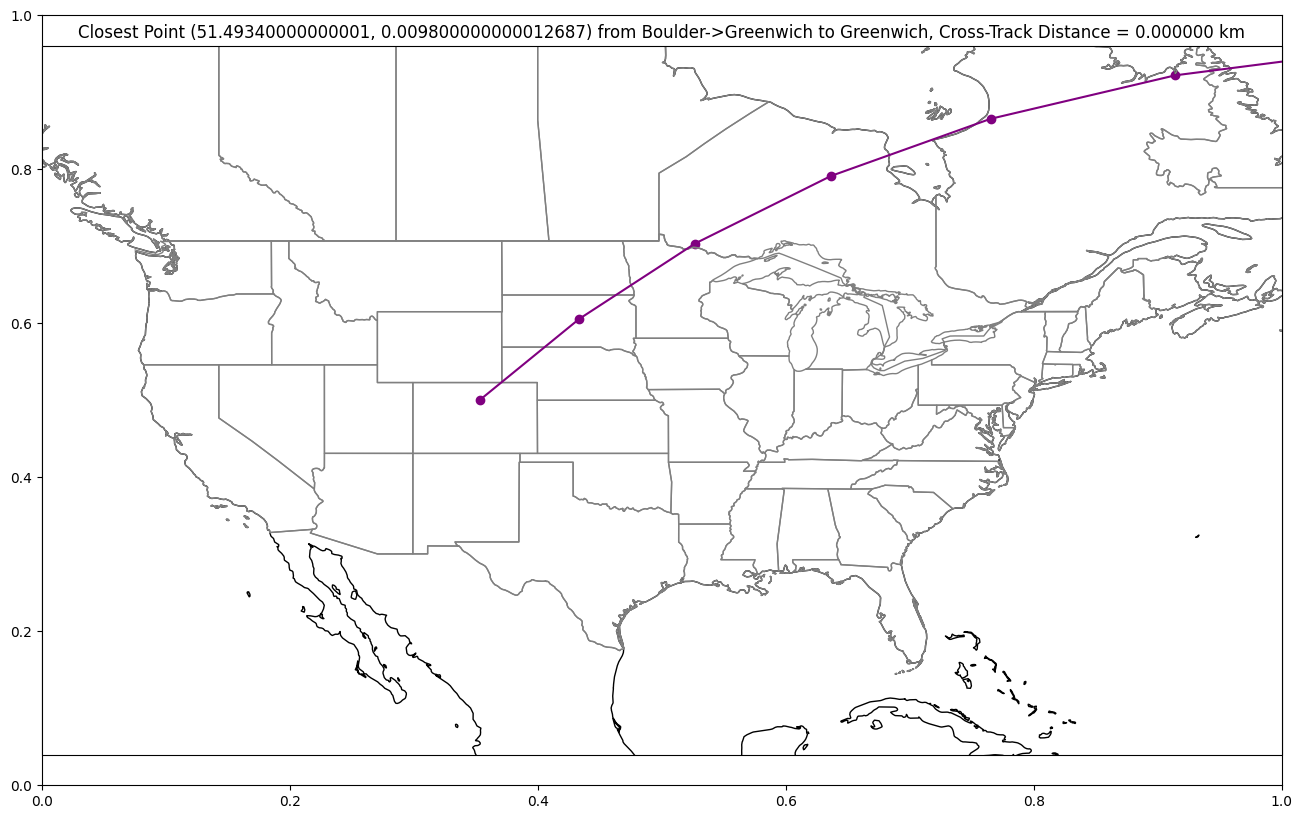

In [13]:
plot_cross_track(start_point="boulder", end_point="greenwich", new_point="greenwich")

Cross Track Distance: 
1593669.5260947915 meters (1593.6695260947915 km)
Along Track Distance: 
2076501.5510165778 meters (2076.5015510165777 km)

Closest Point To Point Along Great Circle Path:
(42.7552524575549, -80.62124342116076)


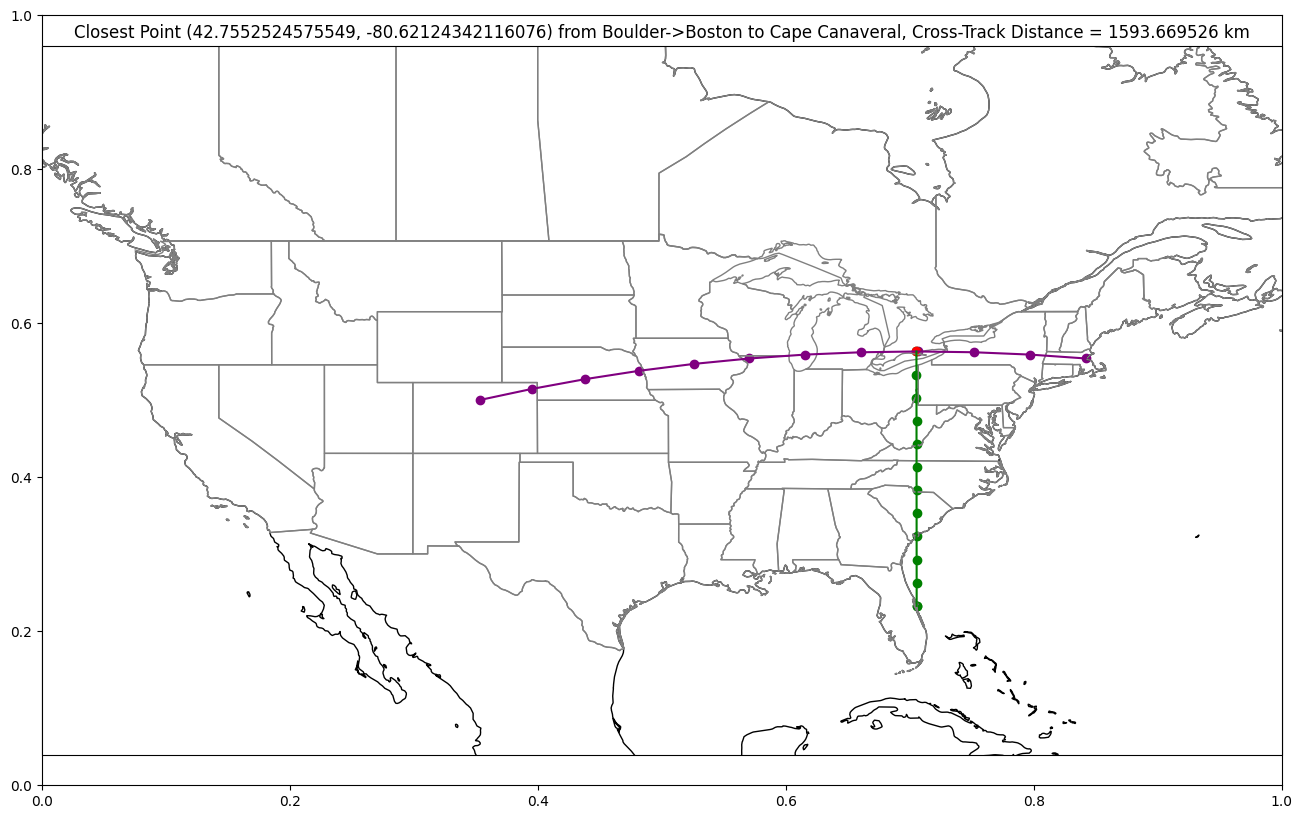

In [14]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="cape canaveral")

Cross Track Distance: 
2577081.0417989404 meters (2577.0810417989405 km)
Along Track Distance: 
3669432.5407487787 meters (3669.4325407487786 km)

Closest Point To Point Along Great Circle Path:
(41.14267768986517, -61.4898025092551)


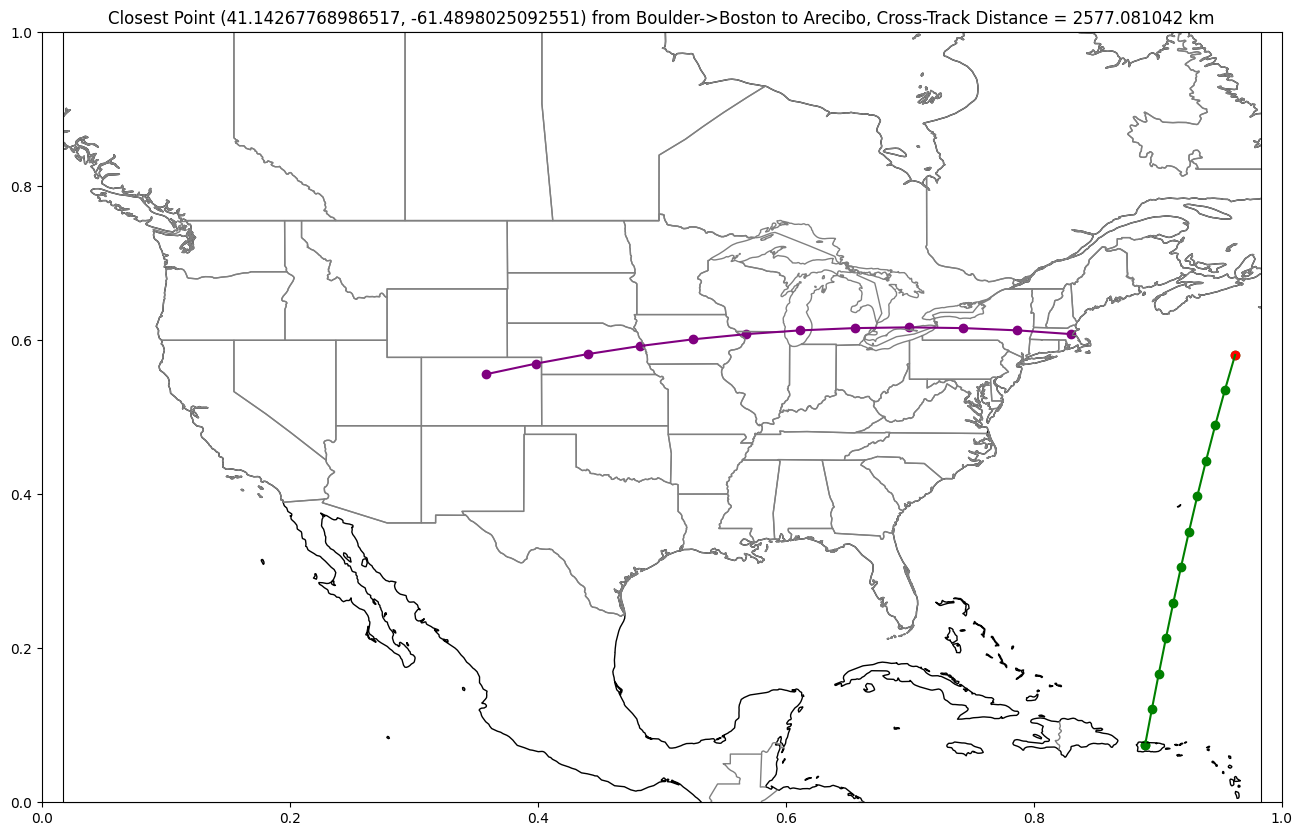

In [15]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="arecibo",
                lat_south=15)

#### Negative Cross-Track Distance: Point lies in the hemiphere to the right of the great circle

Cross Track Distance: 
-744048.9243466781 meters (-744.0489243466781 km)
Along Track Distance: 
1409025.1954944504 meters (1409.0251954944504 km)

Closest Point To Point Along Great Circle Path:
(42.46116756301668, -88.74894120764374)


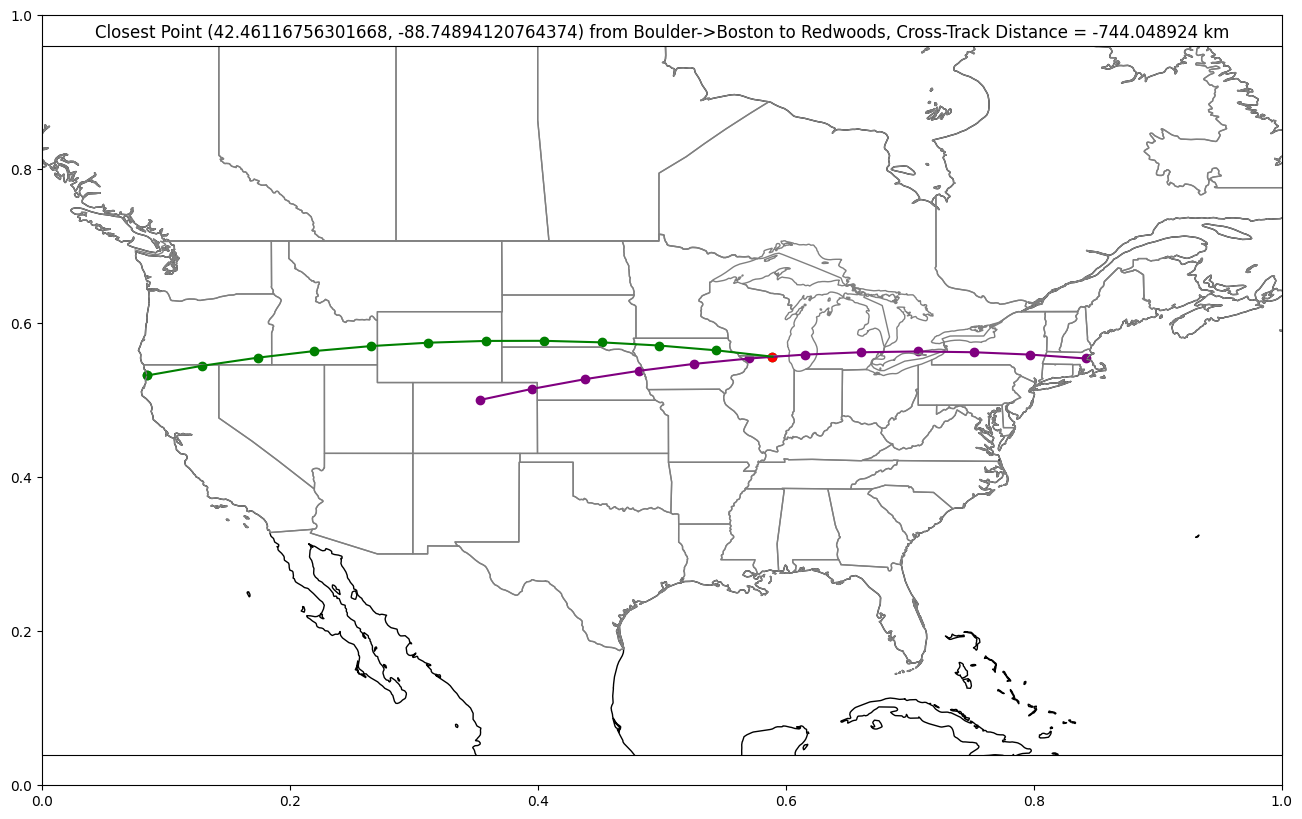

In [16]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="redwoods")

Cross Track Distance: 
-3381043.8402817477 meters (-3381.0438402817476 km)
Along Track Distance: 
7144535.346708466 meters (7144.535346708466 km)

Closest Point To Point Along Great Circle Path:
(28.397359209696102, -26.451361846821612)


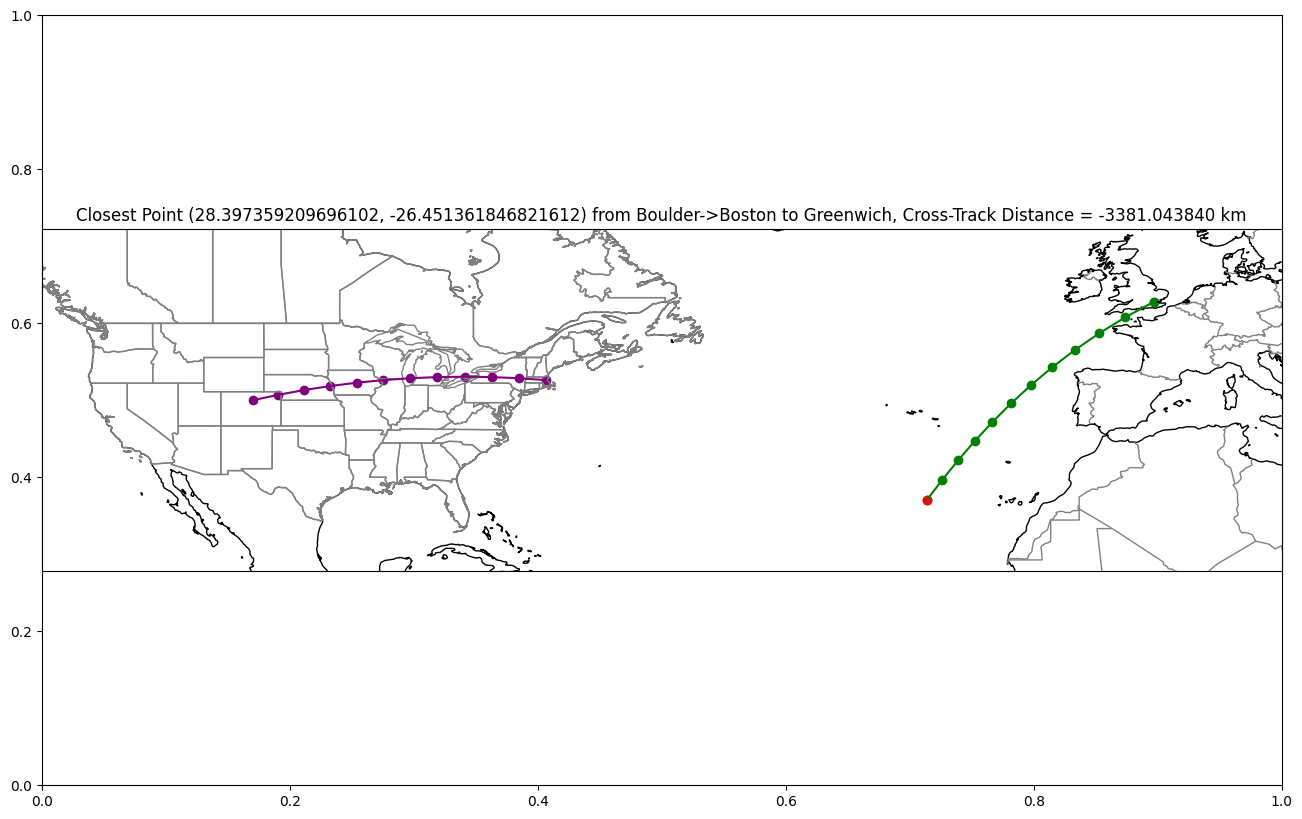

In [17]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="greenwich",
                lon_east=15)

## Determine if a point lies on a great circle arc and path

With and without tolerances (in meters):

In [20]:
def is_point_on_arc(start_point=None, end_point=None,
                check_point=None, tolerance=0):
    # tolerance in meters
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])
    check_lon = np.deg2rad(location_df.loc[check_point, "longitude"])
    check_lat = np.deg2rad(location_df.loc[check_point, "latitude"])

    # Verify not meridian (longitude passes through the poles)
    if np.sin(lon1 - lon2) == 0:
        print("Invalid inputs: start/end points are meridians")
        return np.nan
    
    # verify not anitpodal (diametrically opposite, points)
    if lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi:
        print("Invalid inputs: start/end points are antipodal")
        return np.nan
    # account for tolerance based on cross-track distance from arc
    ct_distance = cross_track_distance(start_point, end_point, check_point)
    print(f"Cross-Track Distance = {ct_distance} meters")
    if np.abs(ct_distance) <= tolerance:
        return True

    # determine expected latitude
    num = np.sin(lat1)*np.cos(lat2)*np.sin(check_lon-lon2)-np.sin(lat2)*np.cos(lat1)*np.sin(check_lon-lon1)
    den = np.cos(lat1)*np.cos(lat2)*np.sin(lon1-lon2)
    new_lat = np.arctan(num/den)
    expected_lat = np.rad2deg(new_lat)
    return check_lat == expected_lat

#### Check if a point lies on a great circle arc

In [21]:
is_point_on_arc("boulder", "boston", "rockford", tolerance=0)

Cross-Track Distance = 18201.48035911727 meters


False

Cross Track Distance: 
18201.48035911727 meters (18.201480359117273 km)
Along Track Distance: 
1378654.5186233774 meters (1378.6545186233775 km)

Closest Point To Point Along Great Circle Path:
(42.434120910748035, -89.11630028269333)


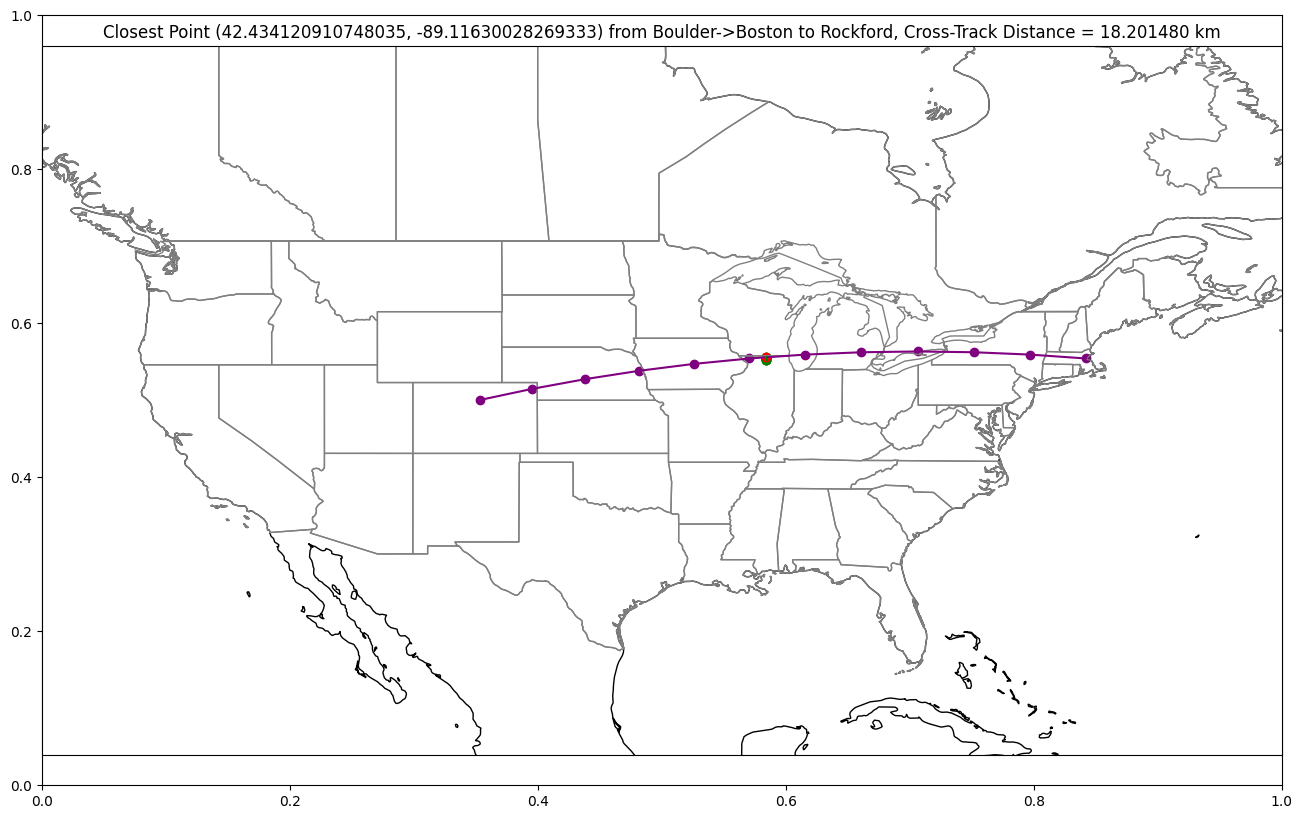

In [22]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="rockford")

Cross Track Distance: 
18201.48035911727 meters (18.201480359117273 km)
Along Track Distance: 
1378654.5186233774 meters (1378.6545186233775 km)

Closest Point To Point Along Great Circle Path:
(42.434120910748035, -89.11630028269333)


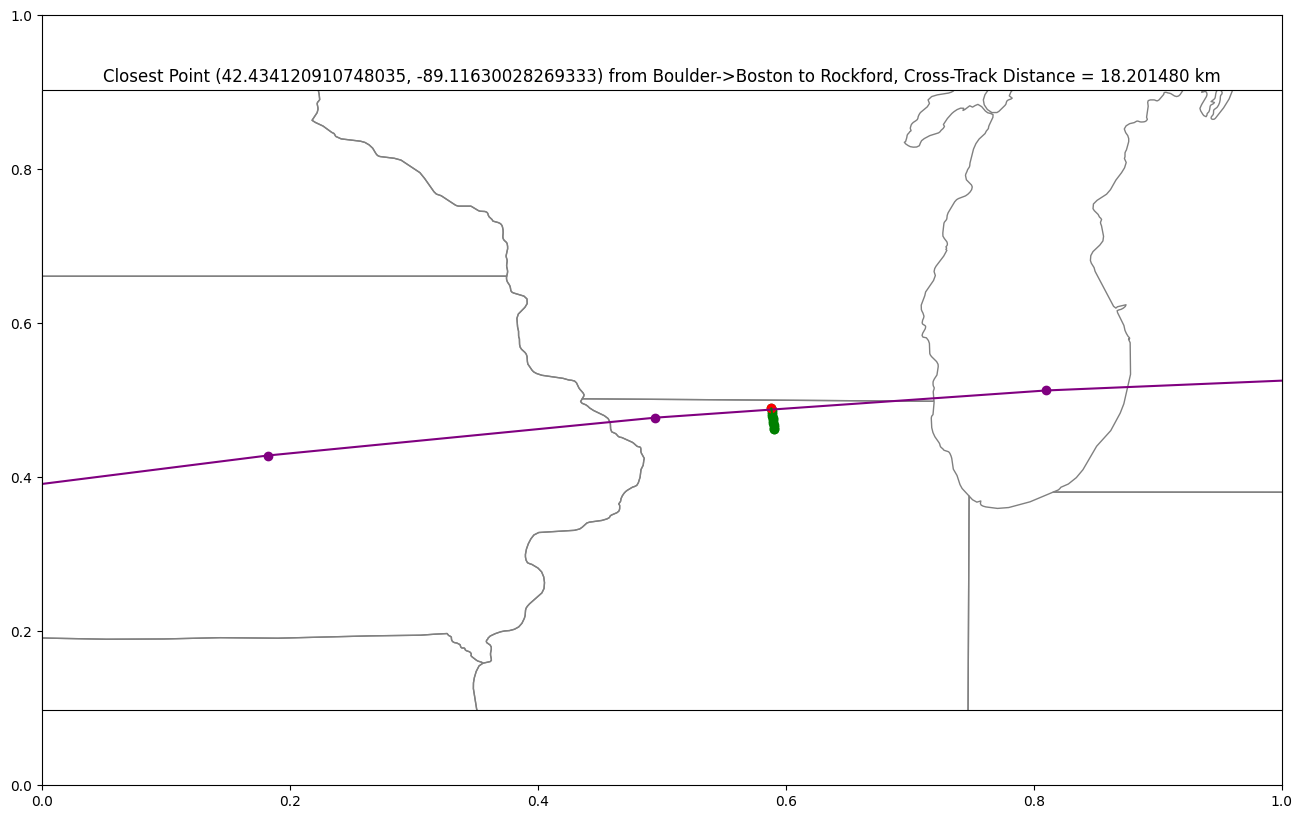

In [23]:
plot_cross_track(start_point="boulder", end_point="boston", new_point="rockford", 
                 lon_west=-95, lon_east=-85,
                 lat_south=40, lat_north=45)

In [24]:
# increase tolerance to capture point
print("tolerance = 0")
print(is_point_on_arc("boulder", "boston", "rockford", tolerance=0))
print("\ntolerance >= cross-track distance")
print(is_point_on_arc("boulder", "boston", "rockford", tolerance=18202))

tolerance = 0
Cross-Track Distance = 18201.48035911727 meters
False

tolerance >= cross-track distance
Cross-Track Distance = 18201.48035911727 meters
True


---

## Summary
Calculating and plotting the cross-track and along-trackd distance of a great circle arc/path and a point.

### What's next?

Determine when a great circle path crosses a given parallel and the maximum and minimum latitude coordinates of a great circle path.

## Resources and references

- [Aviation Formulary V1.47](https://edwilliams.org/avform147.htm)
- [Moveable Type Script](https://www.movable-type.co.uk/scripts/latlong.html)